# Best PR Run Replica
This notebook executes the run to retrieve predictions for surface air temperature, using CNN-Multilayer Perceptron. If you are running on your own, please make sure to change the paths to match your own runtime.

To submit to the leaderboard, you need to concatenate this with a separate prediction set for precipitation rate.

This run achieves:
* 0.6304 on public leaderboard / 0.6405 on private leaderboard

It differs from most previous runs in that it uses the decadal sampler. It also only trains on SSP 126 and 370 (not 585)!

In [1]:
!git clone https://github.com/kabir-vats/Deep-Climate-Learning.git
!pip install -r Deep-Climate-Learning/requirements.txt

Cloning into 'Deep-Climate-Learning'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 49 (delta 16), reused 36 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (49/49), 229.66 KiB | 20.88 MiB/s, done.
Resolving deltas: 100% (16/16), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━

In [2]:
import sys
sys.path.append('/kaggle/working/Deep-Climate-Learning')

In [3]:
from pytorch_lightning.loggers import WandbLogger
import wandb

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb-key")

wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kabirvats (kabirvats-uc-san-diego) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
from climate_prediction.data_loader import ClimateDecadeDataModule
from climate_prediction.models.CNN_MLP import CNN_MLP
from climate_prediction.train import ClimateEmulationModule
from climate_prediction.util import compare_preds
import lightning.pytorch as pl
import numpy as np
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
config = {
    "data": {
        "path": "/kaggle/input/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["pr"],
        "train_member_ids": [0,1,2],
        "val_member_id": 0,
        "target_member_id": 0,
        "train_ssps": ["ssp370", "ssp126"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "val_months": 120,
        "batch_size": 64,
        "num_workers": 4,
        "sequence_length": 1,
    },
    "optimizer": {
        "lr": 2e-4,
        "scheduler": {
            "type": "OneCycle",
            "max_lr": 1e-3,
            "epochs": 30,
            "pct_start": 0.25,
            "anneal_strategy": 'cos',
            "div_factor": 10,
            "final_div_factor": 1e3,
            "cycle_momentum": False,
            'three_phase': True,
        }
    },
    "trainer": {
        "max_epochs": 30,
        "accelerator": "auto",
        "devices": "auto",
        "precision": "32",
        "deterministic": False,
        "num_sanity_val_steps": 0,
    },
    "model_type": "CNN_MLP",
    "model": {
        "lat": 48,
        "lon": 72,
        "channels_last": False,
        "seq_len": 1,
        "in_var_ids": ["a","b","c","d","e","f","g","h","9","10", "11", "12"],
        "out_var_ids": ["PR"],
        "hidden_size": 512,
        "seq_to_seq": False,
        "dropout": 0,
    },
    "loss": {
        "version": "Ramp",
        "wait_epochs": 15,
        "ramp_epochs": 2,
        "train_weights": {
            "tas": {"monthly_rmse": 0.1, "time_mean": 0.3, "time_std": 1.0},
            "pr": {"monthly_rmse": 0.1, "time_mean": 0.3, "time_std": 1},
        },
    },
    "seed": 42,
}

pl.seed_everything(config["seed"])

INFO: Seed set to 42


42

In [16]:
checkpoint_callback = ModelCheckpoint(
    save_top_k=0
)

wandb_logger = WandbLogger(
    project="HK(N+1)",
    name="rep attempt v1",
    config=config                    
)

early_stop_callback = EarlyStopping(
    monitor="val/loss/crit2",   # the metric to monitor
    min_delta=0.0001,            # minimum change to qualify as improvement
    patience=10,                 # how many epochs to wait before stopping
    verbose=True,
    mode="min"                  # minimize the metric
)

datamodule = ClimateDecadeDataModule(**config["data"])
model = CNN_MLP(**config["model"])
lightning_module = ClimateEmulationModule(model, config["data"]["output_vars"], config["loss"], config["optimizer"])

trainer = pl.Trainer(**config["trainer"], logger=wandb_logger, callbacks=[early_stop_callback, checkpoint_callback])
trainer.fit(lightning_module, datamodule=datamodule)
wandb.finish()

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


['pr']
['pr']


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(
INFO: 
  | Name       | Type                    | Params | Mode 
---------------------------------------------------------------
0 | model      | CNN_MLP                 | 2.1 M  | train
1 | ramp1      | L1Loss                  | 0      | train
2 | ramp2      | AreaWeightedClimateLoss | 0      | train
3 | criterion1 | L1Loss                  | 0      | train
4 | criterion2 | AreaWeightedClimateLoss | 0      | train
---------------------------------------

Using one cycle LR


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.2306, Criterion2 (Custom)=1.3830
[VAL] pr: RMSE=2.8492, Time-Mean RMSE=1.0893, Time-Stddev MAE=1.8156
[Epoch 1] Current LR (group 0): 0.0001390090633825638
[TRAIN]: Criterion1 (MSE)=1.4438, Criterion2 (Custom)=1.4476


INFO: Metric val/loss/crit2 improved. New best score: 1.383


[TRAIN] pr: RMSE=3.0005, Time-Mean RMSE=1.4223, Time-Stddev MAE=1.5320


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0148, Criterion2 (Custom)=0.8715
[VAL] pr: RMSE=2.3194, Time-Mean RMSE=0.6607, Time-Stddev MAE=1.1099
[Epoch 2] Current LR (group 0): 0.0002492731111925445
[TRAIN]: Criterion1 (MSE)=0.9568, Criterion2 (Custom)=0.8043


INFO: Metric val/loss/crit2 improved by 0.512 >= min_delta = 0.0001. New best score: 0.871


[TRAIN] pr: RMSE=2.2235, Time-Mean RMSE=0.5286, Time-Stddev MAE=1.1234


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9440, Criterion2 (Custom)=0.7992
[VAL] pr: RMSE=2.2066, Time-Mean RMSE=0.6280, Time-Stddev MAE=0.9779
[Epoch 3] Current LR (group 0): 0.00041167526685288605
[TRAIN]: Criterion1 (MSE)=0.8672, Criterion2 (Custom)=0.6246


INFO: Metric val/loss/crit2 improved by 0.072 >= min_delta = 0.0001. New best score: 0.799


[TRAIN] pr: RMSE=1.9794, Time-Mean RMSE=0.3595, Time-Stddev MAE=0.9075


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9760, Criterion2 (Custom)=0.8799
[VAL] pr: RMSE=2.2227, Time-Mean RMSE=0.7457, Time-Stddev MAE=1.0326
[Epoch 4] Current LR (group 0): 0.0005980592815475034
[TRAIN]: Criterion1 (MSE)=0.8418, Criterion2 (Custom)=0.5646
[TRAIN] pr: RMSE=1.9018, Time-Mean RMSE=0.3258, Time-Stddev MAE=0.8047


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9289, Criterion2 (Custom)=0.7545
[VAL] pr: RMSE=2.1473, Time-Mean RMSE=0.6051, Time-Stddev MAE=0.8989
[Epoch 5] Current LR (group 0): 0.0007761110848643114
[TRAIN]: Criterion1 (MSE)=0.8489, Criterion2 (Custom)=0.5486


INFO: Metric val/loss/crit2 improved by 0.045 >= min_delta = 0.0001. New best score: 0.754


[TRAIN] pr: RMSE=1.8890, Time-Mean RMSE=0.3222, Time-Stddev MAE=0.7690


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9488, Criterion2 (Custom)=0.8116
[VAL] pr: RMSE=2.1688, Time-Mean RMSE=0.6553, Time-Stddev MAE=0.9793
[Epoch 6] Current LR (group 0): 0.000914961191999021
[TRAIN]: Criterion1 (MSE)=0.8544, Criterion2 (Custom)=0.5386
[TRAIN] pr: RMSE=1.8880, Time-Mean RMSE=0.3190, Time-Stddev MAE=0.7470


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9356, Criterion2 (Custom)=0.7717
[VAL] pr: RMSE=2.1346, Time-Mean RMSE=0.5960, Time-Stddev MAE=0.9577
[Epoch 7] Current LR (group 0): 0.0009905366579298826
[TRAIN]: Criterion1 (MSE)=0.8363, Criterion2 (Custom)=0.5328
[TRAIN] pr: RMSE=1.8659, Time-Mean RMSE=0.3138, Time-Stddev MAE=0.7418


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9099, Criterion2 (Custom)=0.7439
[VAL] pr: RMSE=2.1122, Time-Mean RMSE=0.5627, Time-Stddev MAE=0.9318
[Epoch 8] Current LR (group 0): 0.0009897346909206123
[TRAIN]: Criterion1 (MSE)=0.8259, Criterion2 (Custom)=0.5335


INFO: Metric val/loss/crit2 improved by 0.011 >= min_delta = 0.0001. New best score: 0.744


[TRAIN] pr: RMSE=1.8585, Time-Mean RMSE=0.3174, Time-Stddev MAE=0.7398


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9471, Criterion2 (Custom)=0.7431
[VAL] pr: RMSE=2.1399, Time-Mean RMSE=0.5969, Time-Stddev MAE=0.8807
[Epoch 9] Current LR (group 0): 0.0009126943308907458
[TRAIN]: Criterion1 (MSE)=0.8217, Criterion2 (Custom)=0.5313


INFO: Metric val/loss/crit2 improved by 0.001 >= min_delta = 0.0001. New best score: 0.743


[TRAIN] pr: RMSE=1.8521, Time-Mean RMSE=0.3160, Time-Stddev MAE=0.7368


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.8996, Criterion2 (Custom)=0.7054
[VAL] pr: RMSE=2.0927, Time-Mean RMSE=0.5254, Time-Stddev MAE=0.8822
[Epoch 10] Current LR (group 0): 0.0007727723435621517
[TRAIN]: Criterion1 (MSE)=0.8214, Criterion2 (Custom)=0.5232


INFO: Metric val/loss/crit2 improved by 0.038 >= min_delta = 0.0001. New best score: 0.705


[TRAIN] pr: RMSE=1.8477, Time-Mean RMSE=0.3065, Time-Stddev MAE=0.7285


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.8928, Criterion2 (Custom)=0.6816
[VAL] pr: RMSE=2.0756, Time-Mean RMSE=0.4854, Time-Stddev MAE=0.8753
[Epoch 11] Current LR (group 0): 0.0005942275097006766
[TRAIN]: Criterion1 (MSE)=0.8090, Criterion2 (Custom)=0.5272


INFO: Metric val/loss/crit2 improved by 0.024 >= min_delta = 0.0001. New best score: 0.682


[TRAIN] pr: RMSE=1.8415, Time-Mean RMSE=0.3124, Time-Stddev MAE=0.7323


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.8964, Criterion2 (Custom)=0.6710
[VAL] pr: RMSE=2.0723, Time-Mean RMSE=0.4835, Time-Stddev MAE=0.8504
[Epoch 12] Current LR (group 0): 0.0004080147925984608
[TRAIN]: Criterion1 (MSE)=0.8037, Criterion2 (Custom)=0.5240


INFO: Metric val/loss/crit2 improved by 0.011 >= min_delta = 0.0001. New best score: 0.671


[TRAIN] pr: RMSE=1.8357, Time-Mean RMSE=0.3076, Time-Stddev MAE=0.7310


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.8880, Criterion2 (Custom)=0.6661
[VAL] pr: RMSE=2.0673, Time-Mean RMSE=0.4747, Time-Stddev MAE=0.8498
[Epoch 13] Current LR (group 0): 0.0002464185641847478
[TRAIN]: Criterion1 (MSE)=0.8016, Criterion2 (Custom)=0.5257


INFO: Metric val/loss/crit2 improved by 0.005 >= min_delta = 0.0001. New best score: 0.666


[TRAIN] pr: RMSE=1.8342, Time-Mean RMSE=0.3117, Time-Stddev MAE=0.7302


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.8871, Criterion2 (Custom)=0.6614
[VAL] pr: RMSE=2.0650, Time-Mean RMSE=0.4684, Time-Stddev MAE=0.8462
[Epoch 14] Current LR (group 0): 0.00013745534675542085
[TRAIN]: Criterion1 (MSE)=0.7993, Criterion2 (Custom)=0.5229


INFO: Metric val/loss/crit2 improved by 0.005 >= min_delta = 0.0001. New best score: 0.661


[TRAIN] pr: RMSE=1.8314, Time-Mean RMSE=0.3072, Time-Stddev MAE=0.7295


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.8866, Criterion2 (Custom)=0.6582
[VAL] pr: RMSE=2.0633, Time-Mean RMSE=0.4647, Time-Stddev MAE=0.8429
[Epoch 15] Current LR (group 0): 9.999954434176051e-05
[TRAIN]: Criterion1 (MSE)=0.7988, Criterion2 (Custom)=0.5233


INFO: Metric val/loss/crit2 improved by 0.003 >= min_delta = 0.0001. New best score: 0.658


[TRAIN] pr: RMSE=1.8307, Time-Mean RMSE=0.3087, Time-Stddev MAE=0.7283


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.8851, Criterion2 (Custom)=0.6602
[VAL] pr: RMSE=2.0629, Time-Mean RMSE=0.4616, Time-Stddev MAE=0.8521
[Epoch 16] Current LR (group 0): 9.886517594362945e-05
[TRAIN]: Criterion1 (MSE)=0.7980, Criterion2 (Custom)=0.5217
[TRAIN] pr: RMSE=1.8301, Time-Mean RMSE=0.3075, Time-Stddev MAE=0.7260


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=0.9419, Criterion2 (Custom)=0.3984
[VAL] pr: RMSE=2.0896, Time-Mean RMSE=0.2744, Time-Stddev MAE=0.4086
[Epoch 17] Current LR (group 0): 9.560023922654671e-05
[TRAIN]: Criterion1 (MSE)=0.8403, Criterion2 (Custom)=0.2869


INFO: Metric val/loss/crit2 improved by 0.260 >= min_delta = 0.0001. New best score: 0.398


[TRAIN] pr: RMSE=1.8622, Time-Mean RMSE=0.0993, Time-Stddev MAE=0.3788


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0437, Criterion2 (Custom)=0.3791
[VAL] pr: RMSE=2.2281, Time-Mean RMSE=0.3626, Time-Stddev MAE=0.2223
[Epoch 18] Current LR (group 0): 9.034723435769042e-05
[TRAIN]: Criterion1 (MSE)=0.9278, Criterion2 (Custom)=0.1426


INFO: Metric val/loss/crit2 improved by 0.019 >= min_delta = 0.0001. New best score: 0.379


[TRAIN] pr: RMSE=1.9790, Time-Mean RMSE=0.0254, Time-Stddev MAE=0.0806


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0216, Criterion2 (Custom)=0.3219
[VAL] pr: RMSE=2.1920, Time-Mean RMSE=0.2529, Time-Stddev MAE=0.2220
[Epoch 19] Current LR (group 0): 8.333543195908618e-05
[TRAIN]: Criterion1 (MSE)=0.9377, Criterion2 (Custom)=0.1322


INFO: Metric val/loss/crit2 improved by 0.057 >= min_delta = 0.0001. New best score: 0.322


[TRAIN] pr: RMSE=1.9966, Time-Mean RMSE=0.0201, Time-Stddev MAE=0.0573


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0299, Criterion2 (Custom)=0.3183
[VAL] pr: RMSE=2.1994, Time-Mean RMSE=0.2562, Time-Stddev MAE=0.2070
[Epoch 20] Current LR (group 0): 7.487086645057235e-05
[TRAIN]: Criterion1 (MSE)=0.9364, Criterion2 (Custom)=0.1306


INFO: Metric val/loss/crit2 improved by 0.004 >= min_delta = 0.0001. New best score: 0.318


[TRAIN] pr: RMSE=1.9937, Time-Mean RMSE=0.0163, Time-Stddev MAE=0.0586


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0295, Criterion2 (Custom)=0.3149
[VAL] pr: RMSE=2.1996, Time-Mean RMSE=0.2507, Time-Stddev MAE=0.2055
[Epoch 21] Current LR (group 0): 6.532297898968887e-05
[TRAIN]: Criterion1 (MSE)=0.9377, Criterion2 (Custom)=0.1299


INFO: Metric val/loss/crit2 improved by 0.003 >= min_delta = 0.0001. New best score: 0.315


[TRAIN] pr: RMSE=1.9939, Time-Mean RMSE=0.0171, Time-Stddev MAE=0.0555


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0308, Criterion2 (Custom)=0.3236
[VAL] pr: RMSE=2.1995, Time-Mean RMSE=0.2679, Time-Stddev MAE=0.2054
[Epoch 22] Current LR (group 0): 5.510849298557729e-05
[TRAIN]: Criterion1 (MSE)=0.9378, Criterion2 (Custom)=0.1286
[TRAIN] pr: RMSE=1.9934, Time-Mean RMSE=0.0153, Time-Stddev MAE=0.0546


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0357, Criterion2 (Custom)=0.3131
[VAL] pr: RMSE=2.2057, Time-Mean RMSE=0.2525, Time-Stddev MAE=0.1975
[Epoch 23] Current LR (group 0): 4.467322594998574e-05
[TRAIN]: Criterion1 (MSE)=0.9361, Criterion2 (Custom)=0.1289


INFO: Metric val/loss/crit2 improved by 0.002 >= min_delta = 0.0001. New best score: 0.313


[TRAIN] pr: RMSE=1.9890, Time-Mean RMSE=0.0132, Time-Stddev MAE=0.0587


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0305, Criterion2 (Custom)=0.3121
[VAL] pr: RMSE=2.1987, Time-Mean RMSE=0.2497, Time-Stddev MAE=0.1995
[Epoch 24] Current LR (group 0): 3.447263151830637e-05
[TRAIN]: Criterion1 (MSE)=0.9376, Criterion2 (Custom)=0.1290


INFO: Metric val/loss/crit2 improved by 0.001 >= min_delta = 0.0001. New best score: 0.312


[TRAIN] pr: RMSE=1.9916, Time-Mean RMSE=0.0163, Time-Stddev MAE=0.0546


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0311, Criterion2 (Custom)=0.3142
[VAL] pr: RMSE=2.2002, Time-Mean RMSE=0.2535, Time-Stddev MAE=0.1997
[Epoch 25] Current LR (group 0): 2.4951920896081236e-05
[TRAIN]: Criterion1 (MSE)=0.9377, Criterion2 (Custom)=0.1285
[TRAIN] pr: RMSE=1.9918, Time-Mean RMSE=0.0151, Time-Stddev MAE=0.0548


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0323, Criterion2 (Custom)=0.3094
[VAL] pr: RMSE=2.2000, Time-Mean RMSE=0.2457, Time-Stddev MAE=0.1974
[Epoch 26] Current LR (group 0): 1.652663134264631e-05
[TRAIN]: Criterion1 (MSE)=0.9371, Criterion2 (Custom)=0.1266


INFO: Metric val/loss/crit2 improved by 0.003 >= min_delta = 0.0001. New best score: 0.309


[TRAIN] pr: RMSE=1.9902, Time-Mean RMSE=0.0111, Time-Stddev MAE=0.0553


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0320, Criterion2 (Custom)=0.3080
[VAL] pr: RMSE=2.1992, Time-Mean RMSE=0.2430, Time-Stddev MAE=0.1974
[Epoch 27] Current LR (group 0): 9.564489792372828e-06
[TRAIN]: Criterion1 (MSE)=0.9375, Criterion2 (Custom)=0.1263


INFO: Metric val/loss/crit2 improved by 0.001 >= min_delta = 0.0001. New best score: 0.308


[TRAIN] pr: RMSE=1.9897, Time-Mean RMSE=0.0109, Time-Stddev MAE=0.0550


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0325, Criterion2 (Custom)=0.3075
[VAL] pr: RMSE=2.1998, Time-Mean RMSE=0.2425, Time-Stddev MAE=0.1966
[Epoch 28] Current LR (group 0): 4.369363186889753e-06
[TRAIN]: Criterion1 (MSE)=0.9371, Criterion2 (Custom)=0.1247


INFO: Metric val/loss/crit2 improved by 0.000 >= min_delta = 0.0001. New best score: 0.307


[TRAIN] pr: RMSE=1.9894, Time-Mean RMSE=0.0076, Time-Stddev MAE=0.0553


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0315, Criterion2 (Custom)=0.3071
[VAL] pr: RMSE=2.1985, Time-Mean RMSE=0.2414, Time-Stddev MAE=0.1974
[Epoch 29] Current LR (group 0): 1.1679960158895234e-06
[TRAIN]: Criterion1 (MSE)=0.9372, Criterion2 (Custom)=0.1243


INFO: Metric val/loss/crit2 improved by 0.000 >= min_delta = 0.0001. New best score: 0.307


[TRAIN] pr: RMSE=1.9895, Time-Mean RMSE=0.0071, Time-Stddev MAE=0.0549


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL]: Criterion1 (MSE)=1.0319, Criterion2 (Custom)=0.3072
[VAL] pr: RMSE=2.1989, Time-Mean RMSE=0.2417, Time-Stddev MAE=0.1971
[Epoch 30] Current LR (group 0): 1.0011391468977127e-07
[TRAIN]: Criterion1 (MSE)=0.9371, Criterion2 (Custom)=0.1239


INFO: `Trainer.fit` stopped: `max_epochs=30` reached.


[TRAIN] pr: RMSE=1.9895, Time-Mean RMSE=0.0063, Time-Stddev MAE=0.0550


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
lr,▂▃▄▅▆▇██▇▆▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/loss,█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▃▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss/crit1,█▃▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▂▃▃▃▃▃▃▃
train/loss/crit2,█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/pr/rmse,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂
train/pr/time_mean_rmse,█▄▃▃▃▃▃▃▃▂▃▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/pr/time_std_mae,█▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
val/loss,█▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss/crit1,█▄▂▃▂▂▂▂▂▁▁▁▁▁▁▁▂▄▄▄▄▄▄▄▄▄▄▄▄▄


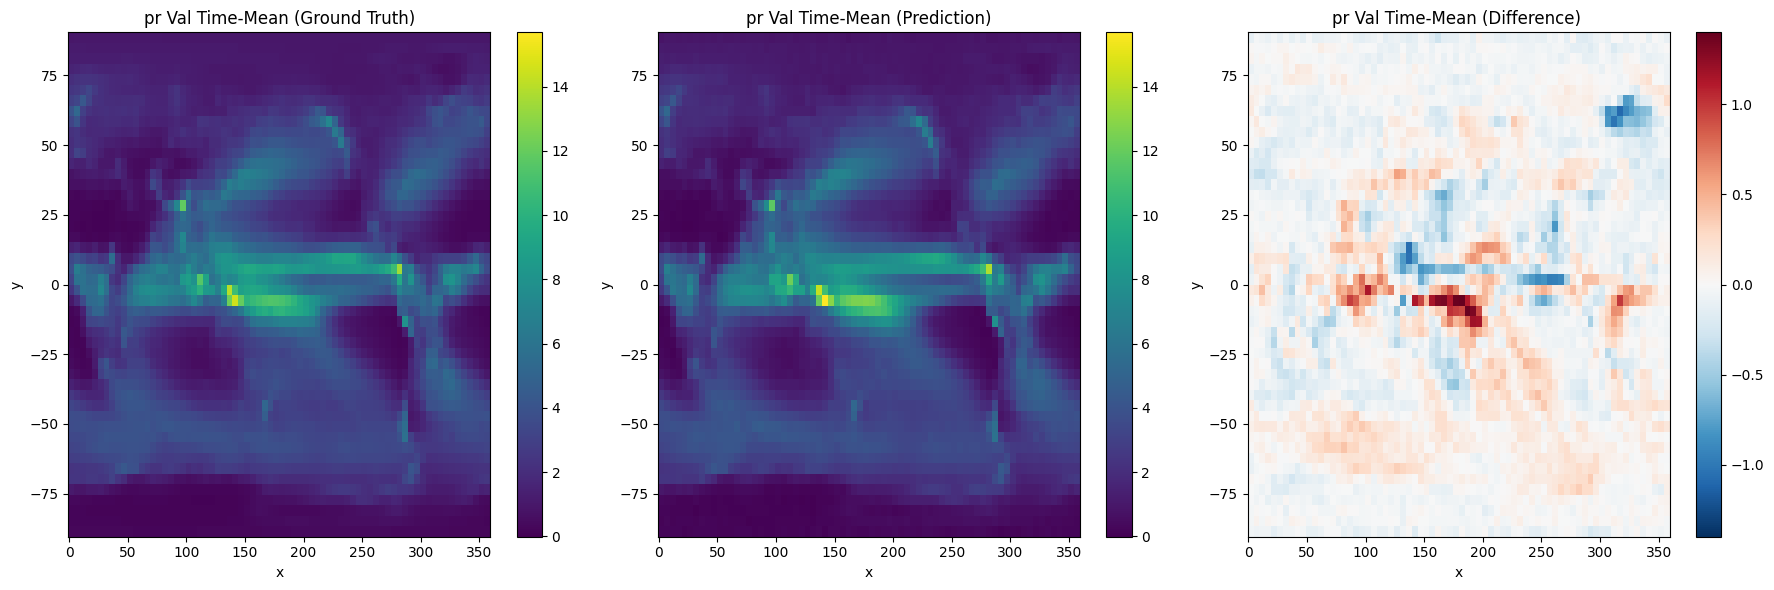

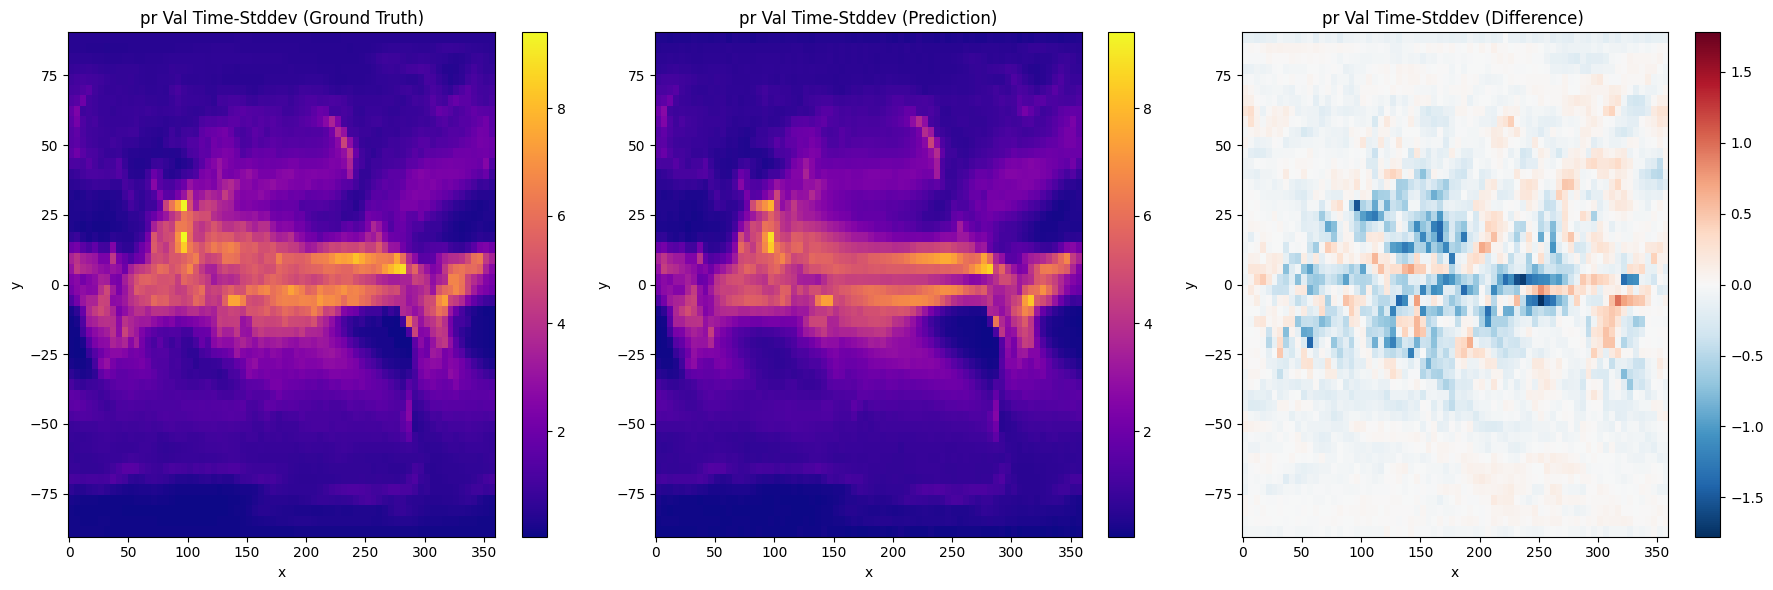

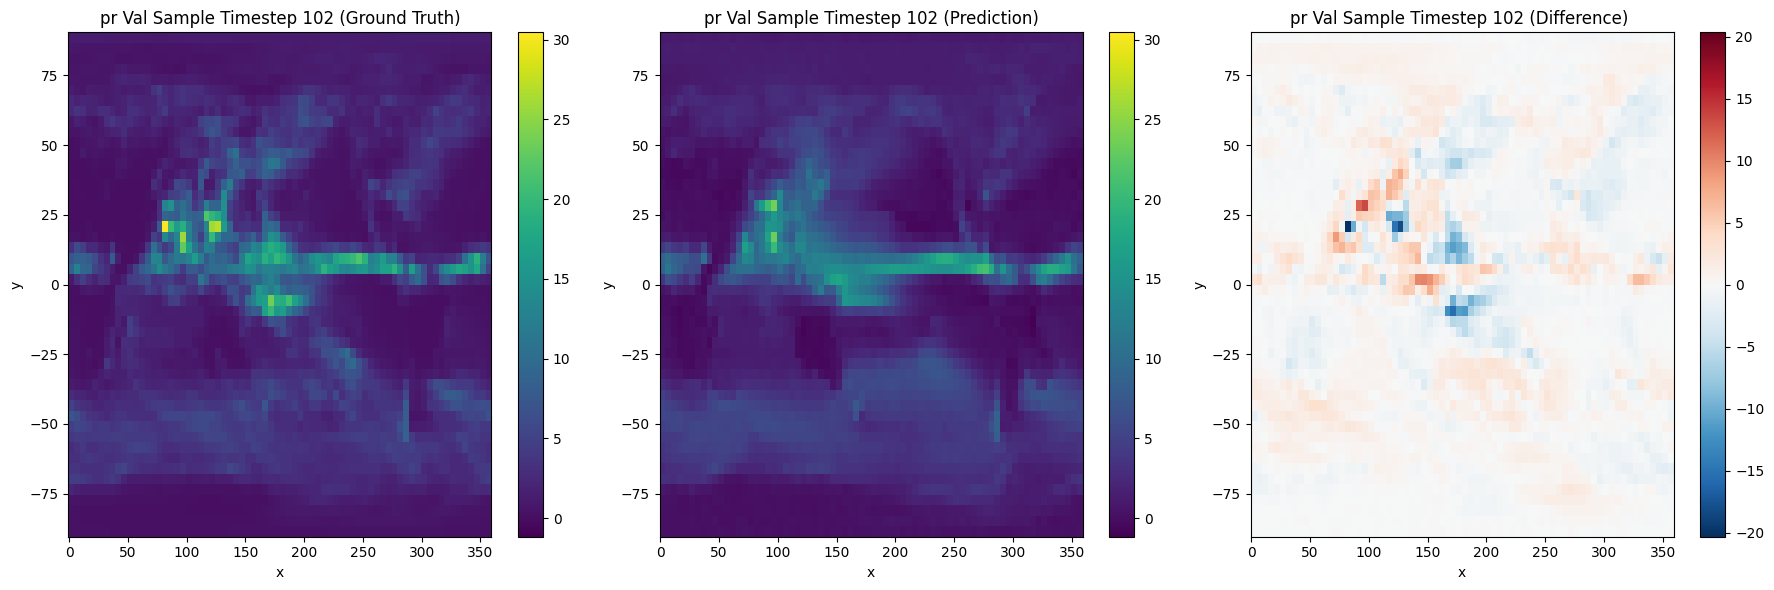

In [17]:
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")
compare_preds(datamodule, val_preds, val_trues)

In [18]:
# To submit:
trainer = pl.Trainer(**config["trainer"], logger=False)
trainer.test(lightning_module, datamodule=datamodule)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Testing: |          | 0/? [00:00<?, ?it/s]

✅ Submission saved to: submissions/kaggle_submission_20250609_211913.csv with 1244160 rows


[{}]